# Решающее дерево

Отметим, что решающее дерево состоит из вершин, в которых записывает некоторое условие, а в листах дерева - прогноз. Условия во внутренних вершинах выбираются простыми. Наиболее частый вариант - проверка лежит ли значение некоторого признака $x^j$ левее порога $t$:

$[x^j \leq t]$

Легко заметить, что такое условие зависит только от одного признака. Прогноз в листе является вещественным числом, если решается задача регрессии. Если же решается задача классификации, то в качестве прогноза выступает или класс или распределение вероятностей классов.

Запишем некоторую функцию ошибки следующим образом: есть набор данных $X_m$, есть номер рассматриваемого признака $j$ и есть порог $t$.

$L(X_m, j, t) \rightarrow \underset{j,t}{min}$

Осуществим перебор всех возможных признаков $j$ и порогов $t$ для этих признаков. Каждый раз исходное множество будет разбиваться на два подмножества:

$X_l = \{x \in X_m | [ x^j \leq t ] \}$ и $X_к = \{x \in X_m | [ x^j > t ] \}$

Такую процедуру можно продолжить для каждого получившегося множества (рекурсивно вызывать функцию деления для получающихся подмножеств).

Необходимо отметить, что если вершина была объявлена листом, необходимо сделать прогноз для этого листа. Для задачи регрессии берется среднее значение по этой выборке,
для задачи классификации возвращается тот класс, которые наиболее популярен в выборке. Можно указывать вероятность классов в листе.

Для каждого разбиения необходимо расчитывать функцию потерь:

$L(X_m, j, t) = \frac{|X_l|}{|X_m|}H(X_l) + \frac{|X_r|}{|X_m|}H(X_r)$,

где $H(X)=\sum\limits_{k=1}^{K} p_k(1 - p_k)$ - критерий информативности Джинни.

$p_k$ - доля объектов класса $k$ в выборке X:

$p_k=\frac{1}{|X|}\sum\limits_{i \in X}{[y_i = k]}$

В задаче работаем только с числовыми данными и строим дерево классификации.

Данные сгенерированы случайным образом.

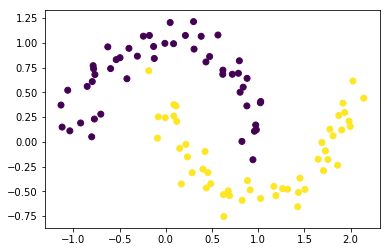

In [1]:
from sklearn.datasets import make_blobs, make_moons
import matplotlib.pyplot as plt
import numpy as np
import pandas  as pd
%matplotlib inline

x, y = make_moons(n_samples=100, noise=0.1)
plt.scatter(x[:,0], x[:,1], c = y)

x_pd = pd.DataFrame(x)
x_pd['y'] = y


## Задание 1

Напишите функцию, которая получает на вход матрицу данных ($x$) и целевые переменные ($y$), на выходе функция возвращает номер признака ($i$), порог разбиения($t$), значение в листовой вершине слева ($y_l$) и значение в листовой вершине справа ($y_r$).
Постарайтесь учесть, что пороги разбиения должны лежать строго по середине между ближайшими обектами.

Необходимо учесть:

1. Разбиений не требуется, если в получившемся множестве находятся объекты одного класса.
2. Количество различных классов объектов в целевой переменной может быть больше двух.


1. Сортируем фичу, считаем пороги между значениями, потом делим множество по каждому порогу и определяем функцию потерь
2. делаем это для всех фич
3. берем фичу и порог с минимальной функцией потерь и делим исходное множество по ней, 
4. получившиеся множества снова делим по следующей фиче и соответствующему порогу с минимальной функцией потерь
5. делаем это пока не закончатся фичи

In [2]:
#Получаем все пороговые значения для фичи (переделать чтобы датафрейм был параметром)

def get_thresholds_by_feature(df,feature_name):
    
    thresholds = np.array([])
    
    df_sorted = np.array(df.sort_values(by=[feature_name]))
    
    for i in range(df_sorted.shape[0]-1):
        threshold_value = (df_sorted[i][feature_name] + df_sorted[i+1][feature_name])/2
        thresholds = np.append(thresholds,threshold_value)
        
    return thresholds

In [3]:
#ПОлучаем критерий Джинни

def get_jinny(df):  
    
    jinny = 0
    
    for class_name in np.unique(y):
        
        pk = df[df==class_name].shape[0]/df.shape[0]
        
        jinny = jinny + pk * (1 - pk)
    
    return jinny

In [4]:
#Получаем функцию потерь

def get_loss_function(df_left,df_right):
    
    df_left_len = df_left.shape[0]
    df_right_len = df_right.shape[0]
    df_len = df_left_len + df_right_len
    
    return df_left_len*get_jinny(df_left)/df_len + df_right_len*get_jinny(df_right)/df_len

In [5]:
#Получаем порог с минимальной функцией потерь (переделать чтобы датафрейм был параметром)

def split_dataframe_by_thresholds(df,feature_name,thresholds):
    
    loss_functions = []          
    
    for threshold in thresholds:
        
        y_left = y[df[feature_name] < threshold]
        
        y_right = y[df[feature_name] > threshold]                
        
        loss_functions.append(get_loss_function(y_left,y_right))            
    
    return [feature_name,thresholds[loss_functions==np.min(loss_functions)][0],np.min(loss_functions)]

In [6]:
#Получаем порог с минимальной функцией потерь для каждой фичи (переделать чтобы датафрейм был параметром)

def get_tree_thresholds(df):
    
    thresholds = []
    
    for class_name in np.unique(y):
        thresholds.append(split_dataframe_by_thresholds(df,class_name,get_thresholds_by_feature(df,class_name)))
        
    return thresholds

In [7]:
#строим дерево с глубиной 1

def build_tree_depth_1(df):        
    
    #берем пороги по обучающей выборке
    
    tree_thresholds = get_tree_thresholds(x_pd)
        
    tree_thresholds_sorted = np.array(pd.DataFrame(tree_thresholds).sort_values(by=[2]))   
    
    feature = int(tree_thresholds_sorted[0][0])
    threshold = tree_thresholds_sorted[0][1]
    
    y_pred = list()
    
    left_values = list()    
    right_values = list()
    
    left_pred = list()    
    right_pred = list()
    
    #обучение
    
    for item in x_pd.values:
        
        if item[feature] < threshold:
                    
            left_pred.append(item[len(item)-1])   
                    
        else:
                    
            right_pred.append(item[len(item)-1]) 
            
    #деление по полученным порогам поданного датасета
    
    df = pd.DataFrame(df.transpose())
        
    for item in df.values:
        
        if item[feature] < threshold:
                    
            left_values.append(item[feature])   
                    
        else:
                    
            right_values.append(item[feature])   
            
    left_pd = pd.DataFrame(left_pred)
    right_pd = pd.DataFrame(right_pred)
    
    #классификация
            
    for item in df.values:
                        
        if item[feature] in left_values:
            
            y_pred.append(left_pd[0].value_counts().idxmax())
            
        else:
            
            y_pred.append(right_pd[0].value_counts().idxmax())          
    
    return  np.array(y_pred)

После первого разбиения мы считаем, что в листе дерева будет находиться класс объектов, которых больше всего в этом множестве. Реализуйте классификатор дерева решений в виде функции, которая получает на вход признаки объекта - $x$, на выходе метка класса - $y_{pred}$. Величину порога деления возьмите с точностью до 5 знака после запятой.

Визуализируйте получившиеся результаты классификатора на плоскости. Для этого воспользуйтесь кодом ниже, чтобы построить поверхность. $t$ - порог разбиения $i$ - номер признака.

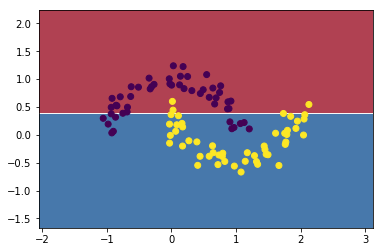

In [9]:
h = .02
x0_min, x0_max = np.min(x[:,0]) - 1, np.max(x[:,0]) + 1
x1_min, x1_max = np.min(x[:,1]) - 1, np.max(x[:,1]) + 1
xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max, h),
                         np.arange(x1_min, x1_max, h))

Z = build_tree_depth_1(np.stack((xx0.ravel(),xx1.ravel())))

Z = Z.reshape(xx0.shape)
cm = plt.cm.RdBu
plt.contourf(xx0, xx1, Z, cmap=cm, alpha=.8)
plt.scatter(x[:,0], x[:,1], c = y)


Проведите процесс разбиение в получившихся листах дерева до глубины 2. Перепишите функцию классификатора. Визуализируйте результаты классификации.

In [61]:
#строим дерево с глубиной 2

def build_tree_depth_2(df):
    
    #берем пороги по обучающей выборке
    
    tree_thresholds = get_tree_thresholds(x_pd)
        
    tree_thresholds_sorted = np.array(pd.DataFrame(tree_thresholds).sort_values(by=[2]))   
    
    feature_1 = int(tree_thresholds_sorted[0][0])
    threshold_1 = tree_thresholds_sorted[0][1]
    
    feature_2 = int(tree_thresholds_sorted[1][0])
    threshold_2 = tree_thresholds_sorted[1][1]
    
    y_pred = list()
    
    left_left_values = list()    
    left_right_values = list()
    
    right_left_values = list()    
    right_right_values = list()
    
    left_left_pred = list()    
    left_right_pred = list()
    
    right_left_pred = list()
    right_right_pred = list()
    
    #обучение
    
    for item in x_pd.values:
        
        if item[feature_1] < threshold_1:
            
            if item[feature_2] < threshold_2:
                    
                left_left_pred.append(item[len(item)-1])   
                
            else :
                
                left_right_pred.append(item[len(item)-1])   
                    
        elif item[feature_2] < threshold_2:
            
            right_left_pred.append(item[len(item)-1]) 
                
        else:
                    
            right_right_pred.append(item[len(item)-1]) 
            
    #деление по полученным порогам поданного датасета
    
    df = pd.DataFrame(df.transpose())
        
    for item in df.values:
        
        if item[feature_1] < threshold_1:
            
            if item[feature_2] < threshold_2:
                    
                left_left_values.append([item[feature_1],item[feature_2]])   
                
            else :
                
                left_right_values.append([item[feature_1],item[feature_2]])   
                    
        elif item[feature_2] < threshold_2:
            
            right_left_values.append([item[feature_1],item[feature_2]]) 
                
        else:
                    
            right_right_values.append([item[feature_1],item[feature_2]]) 
            
    left_left_pd = pd.DataFrame(left_left_pred)
    left_right_pd = pd.DataFrame(left_right_pred)
    right_left_pd = pd.DataFrame(right_left_pred)
    right_right_pd = pd.DataFrame(right_right_pred)
    
    #классификация
            
    for item in df.values:
                        
        if [item[feature_1],item[feature_2]] in left_left_values:
            
            try:
                y_pred.append(left_left_pd[0].value_counts().idxmax())
            except KeyError:
                y_pred.append(left_right_pd[0].value_counts().idxmax())                
        
        elif [item[feature_1],item[feature_2]] in left_right_values:
            
            try:
                y_pred.append(left_right_pd[0].value_counts().idxmax())                
            except KeyError:
                y_pred.append(left_left_pd[0].value_counts().idxmax())                        
            
        elif [item[feature_1],item[feature_2]] in right_left_values:
            
            try:
                y_pred.append(right_left_pd[0].value_counts().idxmax())                
            except KeyError:
                y_pred.append(right_right_pd[0].value_counts().idxmax())                                       
            
        else:
            
            try:
                y_pred.append(right_right_pd[0].value_counts().idxmax())                               
            except KeyError:
                y_pred.append(right_left_pd[0].value_counts().idxmax())                                       
    
    return  np.array(y_pred)    

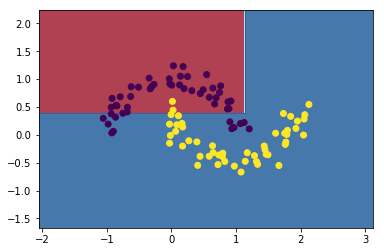

In [62]:
h = .02
x0_min, x0_max = np.min(x[:,0]) - 1, np.max(x[:,0]) + 1
x1_min, x1_max = np.min(x[:,1]) - 1, np.max(x[:,1]) + 1
xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max, h),
                         np.arange(x1_min, x1_max, h))

Z = build_tree_depth_2(np.stack((xx0.ravel(),xx1.ravel())))

Z = Z.reshape(xx0.shape)
cm = plt.cm.RdBu
plt.contourf(xx0, xx1, Z, cmap=cm, alpha=.8)
plt.scatter(x[:,0], x[:,1], c = y)

## Задание №2. Кросс-проверка и  подбор параметров для дерева решений

В задании воспользуемся готовой функцией для построения дерева решений DecisionTreeClassifier. Использовать будем данные с платформы kaggle, где проводится классификация пациентов на здоровых ('Normal') и с заболеванием ('Abnormal'). Подробности о признаках тут: https://www.kaggle.com/uciml/biomechanical-features-of-orthopedic-patients/home
Необходимо построить кросс-проверку (cross_val_score в sklearn.cross_validation ) алгоритма "Дерево решений" на 5 подвыборках, причем дерево должно не ограничиваться по глубине (max_depth), в листовой вершине дерева должен быть хотя бы один объект (min_samples_leaf), минимальное количество объектов должно быть не менее 2 для разбиения (min_samples_split) и random_state=42.
Оцените результаты получившиеся на валидационной выборке с использованием F1-меры, точности и полноты (в параметре scoring к методу cross_val_score необходимо использовать 'f1_weighted', 'precision_weighted', 'recall_weighted'). 

Точность и полнота позволяют провести оценку классификации.
Точность (Precision) - это отношение количества правильно классифицированных объектов класса к количеству объектов, которые классифицированы как данный класс.
Полнота (Recall) - это отношение количества правильно классифицированных объектов класса к количеству объектов данного класса в тестовой выборке.
Введем следующие понятия:

$TP$  — истино-положительное решение;
$TN$ — истино-отрицательное решение;
$FP$ — ложно-положительное решение;
$FN$ — ложно-отрицательное решение.

Тогда 

$Precision = \frac{TP}{TP+FP}$, 

$Recall = \frac{TP}{TP+TN}$.

Точность и полнота изменяются в интервале [0, 1]. Чем выше точность и полнота, тем лучше классификатор. Однако, по двум метрикам очень сложно чудить о качестве классификации, поэтому используют F1-меру:

$F1 = \frac{2 \times Precision \times Recall}{Precision + Recall}$

В нашем задании будем использовать взвешенную сумму F1-меры, точности и полноты для каждого класса.

In [53]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.metrics.classification import f1_score, precision_score, recall_score

In [58]:
df = pd.read_csv('column_2C_weka.csv')
df.columns
X = df[['pelvic_incidence', 'pelvic_tilt numeric', 'lumbar_lordosis_angle',
       'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis']]
y = df['class']

In [64]:
clf = DecisionTreeClassifier(max_depth=None, min_samples_split=2, min_samples_leaf=1,random_state = 42)

In [65]:
cvs_f1_weighted = cross_val_score(clf,X,y,scoring='f1_weighted',cv = 5)
cvs_precision_weighted = cross_val_score(clf,X,y,scoring='precision_weighted',cv = 5)
cvs_recall_weighted = cross_val_score(clf,X,y,scoring='recall_weighted',cv = 5)

In [66]:
cvs_f1_weighted

array([0.42444379, 0.68732315, 0.85145657, 0.91747587, 0.79067321])

In [67]:
cvs_precision_weighted

array([0.58570525, 0.71916509, 0.85275142, 0.92080961, 0.81075269])

In [68]:
cvs_recall_weighted

array([0.43548387, 0.67741935, 0.85483871, 0.91935484, 0.80645161])

#### Выводы

На основе результатов кросс-проверки можно сделать выводы о том, что в данных есть выбросы, потому что в одной из подвыборок все метрики оказались плохими

На оставшихся подвыборках были получены сравнимые значения по всем метрикам

Следует отметить, что по одной метрике не очень удобно проводить оценку. В этой связи, лучшим вариантом кросс-проверки будет использование функции cross_validate из sklearn.model_selection. В нее можно передать несколько метрик и оценивать каждый шаг кросс проверки по нескольким метрикам, причем для тренировочного (return_train_score=True) и валидационного набора данных.
Оцените результаты на тренировочном и тестовом наборе. Объясните получившиеся результаты.


In [3]:
from sklearn.model_selection import cross_validate

In [71]:
cv_results = cross_validate(clf, X, y, return_train_score=True,cv = 5,scoring = ['f1_weighted', 'precision_weighted', 'recall_weighted'])

In [72]:
cv_results

{'fit_time': array([0.00199509, 0.00199461, 0.00199461, 0.00099802, 0.00199366]),
 'score_time': array([0.00199461, 0.00299335, 0.00199509, 0.00299072, 0.00299239]),
 'test_f1_weighted': array([0.42444379, 0.68732315, 0.85145657, 0.91747587, 0.79067321]),
 'test_precision_weighted': array([0.58570525, 0.71916509, 0.85275142, 0.92080961, 0.81075269]),
 'test_recall_weighted': array([0.43548387, 0.67741935, 0.85483871, 0.91935484, 0.80645161]),
 'train_f1_weighted': array([1., 1., 1., 1., 1.]),
 'train_precision_weighted': array([1., 1., 1., 1., 1.]),
 'train_recall_weighted': array([1., 1., 1., 1., 1.])}

#### Выводы

На основе результатов кросс-проверки можно сделать выводы о том, что результаты проверки с помощью метода cross_validate схожи с результатами проверки с помощью метода cross_val_score на тестовой выборке

cross_validate также позволяет оценить результаты проверки на обучающей выборке
все метрики на обучающей выборке в каждой подвыборке достигли максимальных показателей, что указывает на переобучение дерева решений

Дерево было переобучено поскольку оно не было ограничено по глубине (max_depth) и строилось до тех пор, пока в листах дерева не остались объекты одного класса

Подбор параметров для модели можно проводить с помощью GridSearchCV из sklearn.model_selection. Возьмите параметр максимальной глубины дерева от 1 до 20. Относительно этого параметра вычислите средевзвешенную F1-меру для 5 разбиений. Постройте график зависимости F1-меры от максимальной глубины дерева. Получить результаты построения можно методом cv_results_.

Проведите оценку результатов. Почему на тестовой выборке F1-мера не увеличивается. 

In [91]:
from sklearn.model_selection import GridSearchCV

In [92]:
param_grid = {'max_depth':range(1,20)}
gs = GridSearchCV(clf,param_grid,scoring = 'f1_weighted',cv = 5)
gs.fit(X,y)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': range(1, 20)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='f1_weighted',
       verbose=0)

In [93]:
gs.cv_results_

{'mean_fit_time': array([0.00159631, 0.00139632, 0.00159545, 0.00179515, 0.00159469,
        0.00239344, 0.00179529, 0.0017951 , 0.00179515, 0.00159612,
        0.00159502, 0.00179348, 0.00159583, 0.00139008, 0.00159326,
        0.00199318, 0.0017921 , 0.00139246, 0.00179205]),
 'mean_score_time': array([0.00079789, 0.00079799, 0.00079799, 0.00062299, 0.00079765,
        0.0009973 , 0.00119672, 0.00079827, 0.00079756, 0.00059829,
        0.00059848, 0.00039821, 0.00079784, 0.00080171, 0.00119686,
        0.00080042, 0.00059838, 0.00080662, 0.00099158]),
 'mean_test_score': array([0.74505202, 0.69757125, 0.75010411, 0.73110393, 0.7433104 ,
        0.73300684, 0.73923702, 0.73599022, 0.72696151, 0.7339513 ,
        0.73427452, 0.73427452, 0.73427452, 0.73427452, 0.73427452,
        0.73427452, 0.73427452, 0.73427452, 0.73427452]),
 'mean_train_score': array([0.7954419 , 0.84136792, 0.88596518, 0.91304717, 0.94571082,
        0.96566922, 0.98069733, 0.98872984, 0.99596897, 0.99838166,
   

In [94]:
gs.best_params_

{'max_depth': 3}

In [95]:
gs.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [96]:
keys_test = ['split0_test_score',
            'split0_train_score',
            'split1_test_score',
            'split1_train_score',
            'split2_test_score',
            'split2_train_score',
            'split3_test_score',
            'split3_train_score',
            'split4_test_score',
            'split4_train_score']

In [97]:
import matplotlib.pyplot as plt
%matplotlib inline

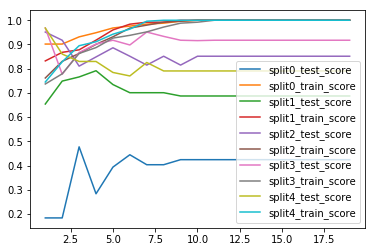

In [98]:
for key in keys:
    plt.plot(range(1,20),gs.cv_results_[key], label=key)
plt.legend()

### Выводы

В большинстве обучающих подвыборок при увеличении max_depth F1-мера увеличивается до значения max_depth = 7 и затем остается почти постоянным

Далее F1-мера перестает увеличиваться потому что данные уже были окончательно разделены деревом до такой степени, что в каждом листе содержатся только представители одного класс

В тестовых подвыборках F1-мера  также достигает набольшего значение при max_depth от 2 до 7 и затем уменьшается и остается постоянной, поскольку далее данные не делятся

То же самое проведите для параметра min_samples_split от 2 до 20.

Проведите оценку результатов. 

In [99]:
param_grid = {'min_samples_split':range(2,20)}
gs = GridSearchCV(clf,param_grid,scoring = 'f1_weighted',cv = 5)
gs.fit(X,y)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_split': range(2, 20)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=0)

In [100]:
gs.cv_results_

{'mean_fit_time': array([0.00199676, 0.00159321, 0.00159607, 0.00189633, 0.00140257,
        0.00189929, 0.00179558, 0.0015955 , 0.00200243, 0.00159607,
        0.00159521, 0.00119638, 0.00179534, 0.00159516, 0.00159636,
        0.00119677, 0.00139618, 0.00119677]),
 'mean_score_time': array([0.00079527, 0.00039883, 0.00099673, 0.00039892, 0.00078959,
        0.00079765, 0.00059857, 0.00059848, 0.00079732, 0.00039878,
        0.00059814, 0.0007977 , 0.00059853, 0.00059862, 0.00079813,
        0.00059838, 0.00059824, 0.00079637]),
 'mean_test_score': array([0.73427452, 0.7369746 , 0.74259632, 0.737862  , 0.75611506,
        0.7582932 , 0.76847343, 0.77103437, 0.75943954, 0.76564453,
        0.76364135, 0.75970334, 0.75699958, 0.75938933, 0.75303247,
        0.75303247, 0.76541065, 0.76541065]),
 'mean_train_score': array([1.        , 0.99676608, 0.98950916, 0.97817122, 0.97575794,
        0.96516675, 0.95882571, 0.94983537, 0.94645253, 0.94004645,
        0.93425833, 0.92329872, 0.92195

In [101]:
gs.best_params_

{'min_samples_split': 9}

In [102]:
gs.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=9,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

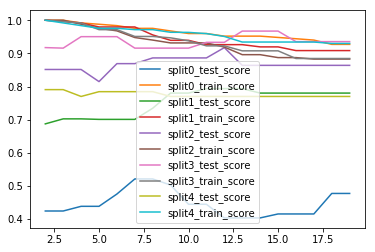

In [103]:
for key in keys:
    plt.plot(range(2,20),gs.cv_results_[key], label=key)
plt.legend()

### Выводы

Наилучшее значение F1-меры было достигнуто при значении min_samples_split = 9, то есть при минимальном необходимом количестве объектов для дальнейшего разделения равном 9. Такое значение было получено поскольку при слишком малом значении этого параметра на сложных данных дерево получится слишком большим и будет чрезмерно разделено, в то врема как при слишком большом значении дерево поделится недостаточно, что приведет сооответственно к переобученности или недообученности

То же самое проведите для параметра min_samples_leaf от 1 до 10.

Проведите оценку результатов. 

In [104]:
param_grid = {'min_samples_leaf':range(1,10)}
gs = GridSearchCV(clf,param_grid,scoring = 'f1_weighted',cv = 5)
gs.fit(X,y)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_leaf': range(1, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=0)

In [105]:
gs.cv_results_

{'mean_fit_time': array([0.00179496, 0.00139837, 0.00159607, 0.00159631, 0.00139599,
        0.00119681, 0.00159621, 0.00159702, 0.00119667]),
 'mean_score_time': array([0.00060225, 0.00079641, 0.00059814, 0.0005981 , 0.00059862,
        0.00079865, 0.00039897, 0.00079641, 0.00099754]),
 'mean_test_score': array([0.73427452, 0.74455593, 0.75950892, 0.75380196, 0.78838918,
        0.77359836, 0.76944619, 0.78589139, 0.75896491]),
 'mean_train_score': array([1.        , 0.97480569, 0.95466542, 0.93304517, 0.92768477,
        0.91727199, 0.9059251 , 0.89643698, 0.8950506 ]),
 'param_min_samples_leaf': masked_array(data=[1, 2, 3, 4, 5, 6, 7, 8, 9],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'params': [{'min_samples_leaf': 1},
  {'min_samples_leaf': 2},
  {'min_samples_leaf': 3},
  {'min_samples_leaf': 4},
  {'min_samples_leaf': 5},
  {'min_samples_leaf': 6},
  {'min_samples_lea

In [106]:
gs.best_params_

{'min_samples_leaf': 5}

In [107]:
gs.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

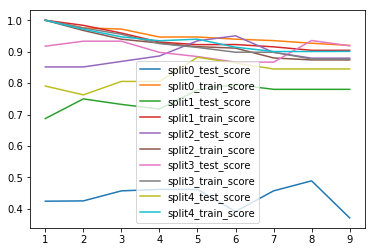

In [108]:
for key in keys:
    plt.plot(range(1,10),gs.cv_results_[key], label=key)
plt.legend()

### Выводы

Наилучшее значение F1-меры было достигнуто при значении min_samples_leaf = 5, то есть при минимальном необходимом количестве объектов для листа дерева равном 5. Такое значение было получено поскольку при слишком малом значении этого параметра на сложных данных дерево получится слишком большим и будет чрезмерно разделено, в то врема как при слишком большом значении дерево поделится недостаточно, что приведет сооответственно к переобученности или недообученности